<img src="../../docs/images/pymsdtorch.png" width=600 />

# (Newer) Latent Space Exploration with Randomized Sparse Mixed Scale Autoencoders, regularized by the availability of image labels

Authors: Eric Roberts and Petrus Zwart

E-mail: PHZwart@lbl.gov, EJRoberts@lbl.gov
___

This notebook highlights some basic functionality with the pyMSDtorch package.

In this notebook we setup autoencoders, with the goal to explore the latent space it generates. In this case however, we will guide the formation of the latent space by including labels to specific images.

The autoencoders we use are based on randomly construct convolutional neural networks in which we can control the number of parameters it contains. This type of control can be beneficial when the amount of data on which one can train a network is not very voluminous, as it allows for better handles on overfitting.

The constructed latent space can be used for unsupervised and supervised exploration methods. In our limited experience, the classifiers that are trained come out of the data are reasonable, but can be improved upon using classic classification methods, as shown further.

___




In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from dlsia.core import helpers
from dlsia.core import train_scripts
from dlsia.core.networks import baggins
from dlsia.core.networks import sparsenet
from dlsia.test_data.twoD import random_shapes
from dlsia.core.utils import latent_space_viewer
from dlsia.viz_tools import plots
from dlsia.viz_tools import plot_autoencoder_image_classification as paic



import matplotlib.pyplot as plt
import matplotlib
from torch.utils.data import DataLoader, TensorDataset
import einops
import umap

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Create some data first

In [2]:
N_train = 500
N_labeled = 200

N_test  = 500
noise_level = 0.50
Nxy = 32

train_data = random_shapes.build_random_shape_set_numpy(n_imgs=N_train,
                                                        noise_level=noise_level,
                                                        n_xy=Nxy)
test_data = random_shapes.build_random_shape_set_numpy(n_imgs=N_test,
                                                       noise_level=noise_level,
                                                       n_xy=Nxy)


In [3]:
plots.plot_shapes_data_numpy(train_data)

In [4]:
which_one = "Noisy" #"GroundTruth" 

batch_size = 100

loader_params = {'batch_size': batch_size, 
                 'shuffle': True} 
train_imgs = torch.Tensor(train_data[which_one]).unsqueeze(1)
train_labels = torch.Tensor(train_data["Label"]).unsqueeze(1)-1
train_labels[N_labeled:]=-1 # remove some labels to highlight 'mixed' training

Ttrain_data = TensorDataset(train_imgs,train_labels)
train_loader = DataLoader(Ttrain_data, **loader_params)

loader_params = {'batch_size': batch_size, 
                 'shuffle': False} 
test_images = torch.Tensor(test_data[which_one]).unsqueeze(1)
test_labels = torch.Tensor(test_data["Label"]).unsqueeze(1)-1
Ttest_data = TensorDataset( test_images, test_labels ) 
test_loader = DataLoader(Ttest_data, **loader_params)


Lets build an autoencoder first.

There are a number of parameters to play with that impact the size of the network:

    - latent_shape: the spatial footprint of the image in latent space. 
      I don't recommend going below 4x4, because it interferes with the 
      dilation choices. This is a bit of a annoyiong feature, we need to fix that. 
      Its on the list.
    - out_channels: the number of channels of the latent image. Determines the
      dimension of latent space: (channels,latent_shape[-2], latent_shape[-1])
    - depth: the depth of the random sparse convolutional encoder / decoder
    - hidden channels: The number of channels put out per convolution. 
    - max_degree / min_degree : This determines how many connections you have per node.
    
    
Other parameters do not impact the size of the network dramatically / at all:

    - in_shape: determined by the input shape of the image.
    - dilations: the maximum dilation should not exceed the smallest image dimension.
    - alpha_range: determines the type of graphs (wide vs skinny). When alpha is large,
                   the chances for skinny graphs to be generated increases. 
                   We don't know which parameter choice is best, so we randomize it's choice.
    - gamma_range: no effect unless the maximum degree and min_degree are far apart.
                   We don't know which parameter choice is best, so we randomize it's choice.
    - pIL,pLO,IO: keep as is. 
    - stride_base: make sure your latent image size can be generated from the in_shape 
                   by repeated division of with this number.

For the classification, specify the number of output classes. Here we work with 4 shapes, so set it to 4.
The dropout rate governs the dropout layers in the classifier part of the networks and doesn't affect the autoencoder part.

In [5]:
autoencoders = []
N_models = 7
for ii in range(N_models):
    torch.cuda.empty_cache()
    autoencoder = sparsenet.SparseAEC(in_shape=(32, 32), 
                                      latent_shape=(8, 8), 
                                      out_classes=4,
                                      depth=40, 
                                      dilations=[1,2,3], 
                                      hidden_channels=3, 
                                      out_channels=2, 
                                      alpha_range=(0.0, 0.25), 
                                      gamma_range=(0.0, 0.5), 
                                      max_degree=10, min_degree=10, 
                                      pIL=0.15, 
                                      pLO=0.15, 
                                      IO=False, 
                                      stride_base=2, 
                                      dropout_rate=0.15,)
    autoencoders.append(autoencoder)
    pytorch_total_params = helpers.count_parameters(autoencoder)
    print( "Number of parameters:", pytorch_total_params)

Number of parameters: 238793
Number of parameters: 270307
Number of parameters: 258797
Number of parameters: 223225
Number of parameters: 237490
Number of parameters: 245600
Number of parameters: 238823


We define two optimizers, one for autoencoding and one for classification. They will be minimized consequetively instead of building a single sum of targets. This avoids choosing the right weight. 
The mini-epochs are the number of epochs it passes over the whole data set to optimize a single atrget function. The autoencoder is done first.

In [6]:
for ii in range(N_models):
    autoencoder = autoencoders[ii]
    torch.cuda.empty_cache()
    learning_rate = 1e-3
    num_epochs=25

    criterion_AE = nn.MSELoss()
    optimizer_AE = optim.Adam(autoencoder.parameters(), lr=learning_rate)

    criterion_label = nn.CrossEntropyLoss(ignore_index=-1)
    optimizer_label = optim.Adam(autoencoder.parameters(), lr=learning_rate)


    rv = train_scripts.autoencode_and_classify_training(net=autoencoder.to('cuda:0'),
                                                        trainloader=train_loader,
                                                        validationloader=test_loader,
                                                        macro_epochs=num_epochs,
                                                        mini_epochs=5,
                                                        criteria_autoencode=criterion_AE,
                                                        minimizer_autoencode=optimizer_AE,
                                                        criteria_classify=criterion_label,
                                                        minimizer_classify=optimizer_label,
                                                        device="cuda:0", 
                                                        show=1, 
                                                        clip_value=100.0)
    plots.plot_training_results_segmentation(rv[2]).show()
    plots.plot_training_results_regression(rv[1]).show()


Epoch    1,  of 25 >-*-< Mini Epoch     1 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 4.3291e-01 | Validation Loss      : 3.3059e-01
Training CC      : 0.1441     | Validation CC        : 0.3795 
** Classification Losses **
Training Loss    : 1.4778e+00 | Validation Loss      : 1.4306e+00
Training F1 Macro: 0.1927     | Validation F1 Macro  : 0.2313 
Training F1 Micro: 0.2456     | Validation F1 Micro  : 0.2640 

Epoch    1,  of 25 >-*-< Mini Epoch     2 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 2.8571e-01 | Validation Loss      : 2.2450e-01
Training CC      : 0.4758     | Validation CC        : 0.5568 
** Classification Losses **
Training Loss    : 1.4656e+00 | Validation Loss      : 1.4262e+00
Training F1 Macro: 0.2161     | Validation F1 Macro  : 0.2103 
Training F1 Micro: 0.2470     | Validation F1 Micro  : 0.2460 

Epoch    1,  of 25 >-*-< Mini Epoch     3 

Epoch    4,  of 25 >-*-< Mini Epoch     4 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 4.8940e-02 | Validation Loss      : 5.1173e-02
Training CC      : 0.8240     | Validation CC        : 0.8130 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 5.0705e-01 | Validation Loss      : 5.1841e-01
Training F1 Macro: 0.7356     | Validation F1 Macro  : 0.8098 
Training F1 Micro: 0.7326     | Validation F1 Micro  : 0.8040 

Epoch    4,  of 25 >-*-< Mini Epoch     5 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 5.0025e-02 | Validation Loss      : 5.1955e-02
Training CC      : 0.8198     | Validation CC        : 0.8097 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 4.2570e-01 | Validation Loss      : 5.2499e-01
Training F1 Macro: 0.8125     | Validation F1 Macro  : 0.7824 
Training F1 Micro: 0.8119     | Validation F1 Micro  : 0.7780 

Epoch    5,  of 25 >-*-< Mini Epoch     1 of 5

Epoch    8,  of 25 >-*-< Mini Epoch     2 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 3.5517e-02 | Validation Loss      : 3.7349e-02
Training CC      : 0.8749     | Validation CC        : 0.8662 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 3.7565e-01 | Validation Loss      : 5.2392e-01
Training F1 Macro: 0.8198     | Validation F1 Macro  : 0.7744 
Training F1 Micro: 0.8205     | Validation F1 Micro  : 0.7740 

Epoch    8,  of 25 >-*-< Mini Epoch     3 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 3.5712e-02 | Validation Loss      : 3.7610e-02
Training CC      : 0.8741     | Validation CC        : 0.8652 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 3.7113e-01 | Validation Loss      : 4.9920e-01
Training F1 Macro: 0.8113     | Validation F1 Macro  : 0.7757 
Training F1 Micro: 0.8111     | Validation F1 Micro  : 0.7740 

Epoch    8,  of 25 >-*-< Mini Epoch     4 of 5

Epoch   11,  of 25 >-*-< Mini Epoch     5 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 3.1421e-02 | Validation Loss      : 3.3014e-02
Training CC      : 0.8911     | Validation CC        : 0.8830 
** Classification Losses **
Training Loss    : 3.9112e-01 | Validation Loss      : 5.3061e-01
Training F1 Macro: 0.7690     | Validation F1 Macro  : 0.7542 
Training F1 Micro: 0.7688     | Validation F1 Micro  : 0.7500 

Epoch   12,  of 25 >-*-< Mini Epoch     1 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 3.0885e-02 | Validation Loss      : 3.3098e-02
Training CC      : 0.8923     | Validation CC        : 0.8826 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 3.9689e-01 | Validation Loss      : 5.2818e-01
Training F1 Macro: 0.7607     | Validation F1 Macro  : 0.7608 
Training F1 Micro: 0.7697     | Validation F1 Micro  : 0.7560 

Epoch   12,  of 25 >-*-< Mini Epoch     2 of

Epoch   15,  of 25 >-*-< Mini Epoch     3 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 2.8917e-02 | Validation Loss      : 3.0945e-02
Training CC      : 0.9001     | Validation CC        : 0.8908 
** Classification Losses **
Training Loss    : 3.7552e-01 | Validation Loss      : 4.7753e-01
Training F1 Macro: 0.7893     | Validation F1 Macro  : 0.7853 
Training F1 Micro: 0.7924     | Validation F1 Micro  : 0.7800 

Epoch   15,  of 25 >-*-< Mini Epoch     4 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 2.8627e-02 | Validation Loss      : 3.0752e-02
Training CC      : 0.9012     | Validation CC        : 0.8917 
** Classification Losses **
Training Loss    : 3.9733e-01 | Validation Loss      : 5.0863e-01
Training F1 Macro: 0.7820     | Validation F1 Macro  : 0.7657 
Training F1 Micro: 0.7968     | Validation F1 Micro  : 0.7660 

Epoch   15,  of 25 >-*-< Mini Epoch     5 

Epoch   19,  of 25 >-*-< Mini Epoch     1 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 2.7455e-02 | Validation Loss      : 2.9704e-02
Training CC      : 0.9058     | Validation CC        : 0.8956 
** Classification Losses **
Training Loss    : 3.7615e-01 | Validation Loss      : 5.0130e-01
Training F1 Macro: 0.7872     | Validation F1 Macro  : 0.7695 
Training F1 Micro: 0.7900     | Validation F1 Micro  : 0.7660 

Epoch   19,  of 25 >-*-< Mini Epoch     2 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 2.7181e-02 | Validation Loss      : 2.9445e-02
Training CC      : 0.9068     | Validation CC        : 0.8963 
** Classification Losses **
Training Loss    : 3.0066e-01 | Validation Loss      : 4.7235e-01
Training F1 Macro: 0.8207     | Validation F1 Macro  : 0.7976 
Training F1 Micro: 0.8276     | Validation F1 Micro  : 0.7940 

Epoch   19,  of 25 >-*-< Mini Epoch     3 

Epoch   22,  of 25 >-*-< Mini Epoch     4 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 2.5199e-02 | Validation Loss      : 2.8626e-02
Training CC      : 0.9128     | Validation CC        : 0.8994 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 3.5925e-01 | Validation Loss      : 5.0057e-01
Training F1 Macro: 0.7944     | Validation F1 Macro  : 0.7792 
Training F1 Micro: 0.8082     | Validation F1 Micro  : 0.7760 

Epoch   22,  of 25 >-*-< Mini Epoch     5 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 2.5400e-02 | Validation Loss      : 2.8719e-02
Training CC      : 0.9123     | Validation CC        : 0.8991 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 4.5009e-01 | Validation Loss      : 5.0703e-01
Training F1 Macro: 0.7851     | Validation F1 Macro  : 0.7667 
Training F1 Micro: 0.7828     | Validation F1 Micro  : 0.7620 

Epoch   23,  of 25 >-*-< Mini Epoch     1 of 5

Epoch    1,  of 25 >-*-< Mini Epoch     1 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 4.9868e-01 | Validation Loss      : 3.5887e-01
Training CC      : 0.2341     | Validation CC        : 0.5114 
** Classification Losses **
Training Loss    : 1.4959e+00 | Validation Loss      : 1.5120e+00
Training F1 Macro: 0.2154     | Validation F1 Macro  : 0.1523 
Training F1 Micro: 0.2387     | Validation F1 Micro  : 0.1720 

Epoch    1,  of 25 >-*-< Mini Epoch     2 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 2.9894e-01 | Validation Loss      : 2.1681e-01
Training CC      : 0.5923     | Validation CC        : 0.6760 
** Classification Losses **
Training Loss    : 1.5420e+00 | Validation Loss      : 1.4904e+00
Training F1 Macro: 0.1430     | Validation F1 Macro  : 0.1566 
Training F1 Micro: 0.1549     | Validation F1 Micro  : 0.1720 

Epoch    1,  of 25 >-*-< Mini Epoch     3 

Epoch    4,  of 25 >-*-< Mini Epoch     4 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 6.3185e-02 | Validation Loss      : 6.5445e-02
Training CC      : 0.7778     | Validation CC        : 0.7651 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 3.8988e-01 | Validation Loss      : 6.4374e-01
Training F1 Macro: 0.8460     | Validation F1 Macro  : 0.7107 
Training F1 Micro: 0.8530     | Validation F1 Micro  : 0.7160 

Epoch    4,  of 25 >-*-< Mini Epoch     5 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 6.5909e-02 | Validation Loss      : 6.6261e-02
Training CC      : 0.7682     | Validation CC        : 0.7636 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 4.5947e-01 | Validation Loss      : 6.3093e-01
Training F1 Macro: 0.7687     | Validation F1 Macro  : 0.7291 
Training F1 Micro: 0.7694     | Validation F1 Micro  : 0.7300 

Epoch    5,  of 25 >-*-< Mini Epoch     1 of 5

Epoch    8,  of 25 >-*-< Mini Epoch     2 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 3.2021e-02 | Validation Loss      : 3.2921e-02
Training CC      : 0.8883     | Validation CC        : 0.8832 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 4.2939e-01 | Validation Loss      : 5.5297e-01
Training F1 Macro: 0.7682     | Validation F1 Macro  : 0.7520 
Training F1 Micro: 0.7672     | Validation F1 Micro  : 0.7500 

Epoch    8,  of 25 >-*-< Mini Epoch     3 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 3.2534e-02 | Validation Loss      : 3.3285e-02
Training CC      : 0.8870     | Validation CC        : 0.8821 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 4.4085e-01 | Validation Loss      : 5.4931e-01
Training F1 Macro: 0.7781     | Validation F1 Macro  : 0.7349 
Training F1 Micro: 0.7799     | Validation F1 Micro  : 0.7340 

Epoch    8,  of 25 >-*-< Mini Epoch     4 of 5

Epoch   11,  of 25 >-*-< Mini Epoch     5 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 2.8070e-02 | Validation Loss      : 2.8861e-02
Training CC      : 0.9028     | Validation CC        : 0.8984 
** Classification Losses **
Training Loss    : 4.5925e-01 | Validation Loss      : 5.7806e-01
Training F1 Macro: 0.7894     | Validation F1 Macro  : 0.7415 
Training F1 Micro: 0.7886     | Validation F1 Micro  : 0.7400 

Epoch   12,  of 25 >-*-< Mini Epoch     1 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 2.7748e-02 | Validation Loss      : 2.8881e-02
Training CC      : 0.9037     | Validation CC        : 0.8982 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 3.4974e-01 | Validation Loss      : 5.9102e-01
Training F1 Macro: 0.8305     | Validation F1 Macro  : 0.7206 
Training F1 Micro: 0.8291     | Validation F1 Micro  : 0.7240 

Epoch   12,  of 25 >-*-< Mini Epoch     2 of

Epoch   15,  of 25 >-*-< Mini Epoch     3 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 2.6014e-02 | Validation Loss      : 2.7109e-02
Training CC      : 0.9102     | Validation CC        : 0.9048 
** Classification Losses **
Training Loss    : 3.8121e-01 | Validation Loss      : 5.9040e-01
Training F1 Macro: 0.8145     | Validation F1 Macro  : 0.7365 
Training F1 Micro: 0.8025     | Validation F1 Micro  : 0.7320 

Epoch   15,  of 25 >-*-< Mini Epoch     4 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 2.5632e-02 | Validation Loss      : 2.6951e-02
Training CC      : 0.9113     | Validation CC        : 0.9055 
** Classification Losses **
Training Loss    : 4.0933e-01 | Validation Loss      : 6.5076e-01
Training F1 Macro: 0.8071     | Validation F1 Macro  : 0.7079 
Training F1 Micro: 0.8157     | Validation F1 Micro  : 0.7040 

Epoch   15,  of 25 >-*-< Mini Epoch     5 

Epoch   19,  of 25 >-*-< Mini Epoch     1 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 2.5135e-02 | Validation Loss      : 2.6330e-02
Training CC      : 0.9140     | Validation CC        : 0.9082 
** Classification Losses **
Training Loss    : 3.8532e-01 | Validation Loss      : 6.4709e-01
Training F1 Macro: 0.8100     | Validation F1 Macro  : 0.7178 
Training F1 Micro: 0.7963     | Validation F1 Micro  : 0.7140 

Epoch   19,  of 25 >-*-< Mini Epoch     2 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 2.4815e-02 | Validation Loss      : 2.5968e-02
Training CC      : 0.9149     | Validation CC        : 0.9092 
** Classification Losses **
Training Loss    : 4.0444e-01 | Validation Loss      : 6.4331e-01
Training F1 Macro: 0.7866     | Validation F1 Macro  : 0.7005 
Training F1 Micro: 0.7942     | Validation F1 Micro  : 0.7000 

Epoch   19,  of 25 >-*-< Mini Epoch     3 

Epoch   22,  of 25 >-*-< Mini Epoch     4 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 2.3507e-02 | Validation Loss      : 2.5435e-02
Training CC      : 0.9191     | Validation CC        : 0.9110 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 4.0367e-01 | Validation Loss      : 5.8848e-01
Training F1 Macro: 0.7892     | Validation F1 Macro  : 0.7306 
Training F1 Micro: 0.7793     | Validation F1 Micro  : 0.7280 

Epoch   22,  of 25 >-*-< Mini Epoch     5 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 2.3707e-02 | Validation Loss      : 2.5606e-02
Training CC      : 0.9184     | Validation CC        : 0.9103 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 3.4115e-01 | Validation Loss      : 6.6638e-01
Training F1 Macro: 0.8263     | Validation F1 Macro  : 0.6798 
Training F1 Micro: 0.8214     | Validation F1 Micro  : 0.6800 

Epoch   23,  of 25 >-*-< Mini Epoch     1 of 5

Epoch    1,  of 25 >-*-< Mini Epoch     1 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 3.4319e-01 | Validation Loss      : 2.7237e-01
Training CC      : 0.2067     | Validation CC        : 0.3921 
** Classification Losses **
Training Loss    : 1.3693e+00 | Validation Loss      : 1.3519e+00
Training F1 Macro: 0.2617     | Validation F1 Macro  : 0.2446 
Training F1 Micro: 0.3244     | Validation F1 Micro  : 0.3400 

Epoch    1,  of 25 >-*-< Mini Epoch     2 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 2.4416e-01 | Validation Loss      : 2.0416e-01
Training CC      : 0.4643     | Validation CC        : 0.5566 
** Classification Losses **
Training Loss    : 1.3419e+00 | Validation Loss      : 1.3186e+00
Training F1 Macro: 0.2415     | Validation F1 Macro  : 0.2679 
Training F1 Micro: 0.3309     | Validation F1 Micro  : 0.3700 

Epoch    1,  of 25 >-*-< Mini Epoch     3 

Epoch    4,  of 25 >-*-< Mini Epoch     4 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 4.8754e-02 | Validation Loss      : 4.8849e-02
Training CC      : 0.8296     | Validation CC        : 0.8254 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 4.3181e-01 | Validation Loss      : 6.2168e-01
Training F1 Macro: 0.8230     | Validation F1 Macro  : 0.7388 
Training F1 Micro: 0.8208     | Validation F1 Micro  : 0.7400 

Epoch    4,  of 25 >-*-< Mini Epoch     5 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 4.8708e-02 | Validation Loss      : 4.9046e-02
Training CC      : 0.8293     | Validation CC        : 0.8246 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 3.9616e-01 | Validation Loss      : 6.0446e-01
Training F1 Macro: 0.7990     | Validation F1 Macro  : 0.7330 
Training F1 Micro: 0.8060     | Validation F1 Micro  : 0.7360 

Epoch    5,  of 25 >-*-< Mini Epoch     1 of 5

Epoch    8,  of 25 >-*-< Mini Epoch     2 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 3.2075e-02 | Validation Loss      : 3.2815e-02
Training CC      : 0.8891     | Validation CC        : 0.8835 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 3.5315e-01 | Validation Loss      : 5.3318e-01
Training F1 Macro: 0.8259     | Validation F1 Macro  : 0.7560 
Training F1 Micro: 0.8310     | Validation F1 Micro  : 0.7580 

Epoch    8,  of 25 >-*-< Mini Epoch     3 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 3.1994e-02 | Validation Loss      : 3.3414e-02
Training CC      : 0.8884     | Validation CC        : 0.8813 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 4.8063e-01 | Validation Loss      : 5.2900e-01
Training F1 Macro: 0.7500     | Validation F1 Macro  : 0.7658 
Training F1 Micro: 0.7408     | Validation F1 Micro  : 0.7640 

Epoch    8,  of 25 >-*-< Mini Epoch     4 of 5

Epoch   11,  of 25 >-*-< Mini Epoch     5 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 2.7977e-02 | Validation Loss      : 2.9308e-02
Training CC      : 0.9033     | Validation CC        : 0.8971 
** Classification Losses **
Training Loss    : 3.4621e-01 | Validation Loss      : 5.5908e-01
Training F1 Macro: 0.8199     | Validation F1 Macro  : 0.7361 
Training F1 Micro: 0.8284     | Validation F1 Micro  : 0.7340 

Epoch   12,  of 25 >-*-< Mini Epoch     1 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 2.7886e-02 | Validation Loss      : 2.9374e-02
Training CC      : 0.9038     | Validation CC        : 0.8968 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 3.8185e-01 | Validation Loss      : 5.6433e-01
Training F1 Macro: 0.7939     | Validation F1 Macro  : 0.7432 
Training F1 Micro: 0.7952     | Validation F1 Micro  : 0.7420 

Epoch   12,  of 25 >-*-< Mini Epoch     2 of

Epoch   15,  of 25 >-*-< Mini Epoch     3 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 2.6021e-02 | Validation Loss      : 2.7814e-02
Training CC      : 0.9102     | Validation CC        : 0.9025 
** Classification Losses **
Training Loss    : 4.1175e-01 | Validation Loss      : 5.6561e-01
Training F1 Macro: 0.7598     | Validation F1 Macro  : 0.7360 
Training F1 Micro: 0.7609     | Validation F1 Micro  : 0.7340 

Epoch   15,  of 25 >-*-< Mini Epoch     4 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 2.6548e-02 | Validation Loss      : 2.7742e-02
Training CC      : 0.9099     | Validation CC        : 0.9030 
** Classification Losses **
Training Loss    : 3.9061e-01 | Validation Loss      : 5.6782e-01
Training F1 Macro: 0.7977     | Validation F1 Macro  : 0.7262 
Training F1 Micro: 0.7885     | Validation F1 Micro  : 0.7260 

Epoch   15,  of 25 >-*-< Mini Epoch     5 

Epoch   19,  of 25 >-*-< Mini Epoch     1 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 2.5652e-02 | Validation Loss      : 2.7535e-02
Training CC      : 0.9120     | Validation CC        : 0.9040 
** Classification Losses **
Training Loss    : 3.8139e-01 | Validation Loss      : 5.7442e-01
Training F1 Macro: 0.7911     | Validation F1 Macro  : 0.7403 
Training F1 Micro: 0.7894     | Validation F1 Micro  : 0.7400 

Epoch   19,  of 25 >-*-< Mini Epoch     2 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 2.4928e-02 | Validation Loss      : 2.6852e-02
Training CC      : 0.9143     | Validation CC        : 0.9060 
** Classification Losses **
Training Loss    : 3.7641e-01 | Validation Loss      : 5.9360e-01
Training F1 Macro: 0.7929     | Validation F1 Macro  : 0.7289 
Training F1 Micro: 0.7933     | Validation F1 Micro  : 0.7260 

Epoch   19,  of 25 >-*-< Mini Epoch     3 

Epoch   22,  of 25 >-*-< Mini Epoch     4 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 2.4035e-02 | Validation Loss      : 2.6644e-02
Training CC      : 0.9173     | Validation CC        : 0.9069 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 4.3958e-01 | Validation Loss      : 5.3175e-01
Training F1 Macro: 0.7599     | Validation F1 Macro  : 0.7611 
Training F1 Micro: 0.7734     | Validation F1 Micro  : 0.7600 

Epoch   22,  of 25 >-*-< Mini Epoch     5 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 2.3959e-02 | Validation Loss      : 2.6698e-02
Training CC      : 0.9174     | Validation CC        : 0.9067 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 4.1188e-01 | Validation Loss      : 5.3878e-01
Training F1 Macro: 0.7632     | Validation F1 Macro  : 0.7382 
Training F1 Micro: 0.7644     | Validation F1 Micro  : 0.7360 

Epoch   23,  of 25 >-*-< Mini Epoch     1 of 5

Epoch    1,  of 25 >-*-< Mini Epoch     1 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 2.2705e-01 | Validation Loss      : 1.7110e-01
Training CC      : 0.2895     | Validation CC        : 0.4784 
** Classification Losses **
Training Loss    : 1.4296e+00 | Validation Loss      : 1.4379e+00
Training F1 Macro: 0.2159     | Validation F1 Macro  : 0.2300 
Training F1 Micro: 0.2618     | Validation F1 Micro  : 0.2780 

Epoch    1,  of 25 >-*-< Mini Epoch     2 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 1.4663e-01 | Validation Loss      : 1.1113e-01
Training CC      : 0.5668     | Validation CC        : 0.6580 
** Classification Losses **
Training Loss    : 1.4465e+00 | Validation Loss      : 1.4491e+00
Training F1 Macro: 0.2175     | Validation F1 Macro  : 0.2241 
Training F1 Micro: 0.2676     | Validation F1 Micro  : 0.2700 

Epoch    1,  of 25 >-*-< Mini Epoch     3 

Epoch    4,  of 25 >-*-< Mini Epoch     4 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 4.0705e-02 | Validation Loss      : 4.1987e-02
Training CC      : 0.8555     | Validation CC        : 0.8483 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 4.8844e-01 | Validation Loss      : 5.9272e-01
Training F1 Macro: 0.7581     | Validation F1 Macro  : 0.7708 
Training F1 Micro: 0.7588     | Validation F1 Micro  : 0.7680 

Epoch    4,  of 25 >-*-< Mini Epoch     5 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 4.1218e-02 | Validation Loss      : 4.2263e-02
Training CC      : 0.8537     | Validation CC        : 0.8473 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 3.4921e-01 | Validation Loss      : 6.1386e-01
Training F1 Macro: 0.8533     | Validation F1 Macro  : 0.7625 
Training F1 Micro: 0.8547     | Validation F1 Micro  : 0.7600 

Epoch    5,  of 25 >-*-< Mini Epoch     1 of 5

Epoch    8,  of 25 >-*-< Mini Epoch     2 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 3.0901e-02 | Validation Loss      : 3.1572e-02
Training CC      : 0.8932     | Validation CC        : 0.8883 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 4.0732e-01 | Validation Loss      : 6.6176e-01
Training F1 Macro: 0.7656     | Validation F1 Macro  : 0.6959 
Training F1 Micro: 0.7941     | Validation F1 Micro  : 0.6960 

Epoch    8,  of 25 >-*-< Mini Epoch     3 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 3.1172e-02 | Validation Loss      : 3.1785e-02
Training CC      : 0.8925     | Validation CC        : 0.8874 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 4.0241e-01 | Validation Loss      : 5.8185e-01
Training F1 Macro: 0.7866     | Validation F1 Macro  : 0.7662 
Training F1 Micro: 0.7794     | Validation F1 Micro  : 0.7680 

Epoch    8,  of 25 >-*-< Mini Epoch     4 of 5

Epoch   11,  of 25 >-*-< Mini Epoch     5 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 2.6409e-02 | Validation Loss      : 2.7631e-02
Training CC      : 0.9087     | Validation CC        : 0.9034 
** Classification Losses **
Training Loss    : 3.9296e-01 | Validation Loss      : 5.9762e-01
Training F1 Macro: 0.7838     | Validation F1 Macro  : 0.7259 
Training F1 Micro: 0.7993     | Validation F1 Micro  : 0.7280 

Epoch   12,  of 25 >-*-< Mini Epoch     1 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 2.6153e-02 | Validation Loss      : 2.7668e-02
Training CC      : 0.9095     | Validation CC        : 0.9033 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 4.4560e-01 | Validation Loss      : 5.7894e-01
Training F1 Macro: 0.7923     | Validation F1 Macro  : 0.7395 
Training F1 Micro: 0.7803     | Validation F1 Micro  : 0.7400 

Epoch   12,  of 25 >-*-< Mini Epoch     2 of

Epoch   15,  of 25 >-*-< Mini Epoch     3 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 2.4907e-02 | Validation Loss      : 2.6037e-02
Training CC      : 0.9151     | Validation CC        : 0.9090 
** Classification Losses **
Training Loss    : 2.6684e-01 | Validation Loss      : 6.1345e-01
Training F1 Macro: 0.8703     | Validation F1 Macro  : 0.7191 
Training F1 Micro: 0.8653     | Validation F1 Micro  : 0.7220 

Epoch   15,  of 25 >-*-< Mini Epoch     4 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 2.4500e-02 | Validation Loss      : 2.5760e-02
Training CC      : 0.9161     | Validation CC        : 0.9100 
** Classification Losses **
Training Loss    : 4.5668e-01 | Validation Loss      : 6.1409e-01
Training F1 Macro: 0.7715     | Validation F1 Macro  : 0.7072 
Training F1 Micro: 0.7539     | Validation F1 Micro  : 0.7140 

Epoch   15,  of 25 >-*-< Mini Epoch     5 

Epoch   19,  of 25 >-*-< Mini Epoch     1 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 2.3498e-02 | Validation Loss      : 2.5206e-02
Training CC      : 0.9196     | Validation CC        : 0.9120 
** Classification Losses **
Training Loss    : 4.0786e-01 | Validation Loss      : 6.6374e-01
Training F1 Macro: 0.7613     | Validation F1 Macro  : 0.6738 
Training F1 Micro: 0.7662     | Validation F1 Micro  : 0.6860 

Epoch   19,  of 25 >-*-< Mini Epoch     2 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 2.3210e-02 | Validation Loss      : 2.5088e-02
Training CC      : 0.9205     | Validation CC        : 0.9125 
** Classification Losses **
Training Loss    : 4.1581e-01 | Validation Loss      : 6.6263e-01
Training F1 Macro: 0.7811     | Validation F1 Macro  : 0.7026 
Training F1 Micro: 0.7859     | Validation F1 Micro  : 0.7040 

Epoch   19,  of 25 >-*-< Mini Epoch     3 

Epoch   22,  of 25 >-*-< Mini Epoch     4 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 2.1984e-02 | Validation Loss      : 2.4769e-02
Training CC      : 0.9244     | Validation CC        : 0.9138 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 3.7742e-01 | Validation Loss      : 6.9879e-01
Training F1 Macro: 0.8009     | Validation F1 Macro  : 0.6706 
Training F1 Micro: 0.8055     | Validation F1 Micro  : 0.6700 

Epoch   22,  of 25 >-*-< Mini Epoch     5 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 2.2753e-02 | Validation Loss      : 2.4884e-02
Training CC      : 0.9230     | Validation CC        : 0.9134 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 3.5456e-01 | Validation Loss      : 6.7225e-01
Training F1 Macro: 0.8287     | Validation F1 Macro  : 0.6901 
Training F1 Micro: 0.8272     | Validation F1 Micro  : 0.6880 

Epoch   23,  of 25 >-*-< Mini Epoch     1 of 5

Epoch    1,  of 25 >-*-< Mini Epoch     1 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 1.7965e-01 | Validation Loss      : 1.1363e-01
Training CC      : 0.4363     | Validation CC        : 0.6745 
** Classification Losses **
Training Loss    : 1.4386e+00 | Validation Loss      : 1.3973e+00
Training F1 Macro: 0.2192     | Validation F1 Macro  : 0.2080 
Training F1 Micro: 0.2644     | Validation F1 Micro  : 0.2740 

Epoch    1,  of 25 >-*-< Mini Epoch     2 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 9.3265e-02 | Validation Loss      : 6.9356e-02
Training CC      : 0.7337     | Validation CC        : 0.7797 
** Classification Losses **
Training Loss    : 1.4639e+00 | Validation Loss      : 1.4196e+00
Training F1 Macro: 0.1890     | Validation F1 Macro  : 0.1770 
Training F1 Micro: 0.2401     | Validation F1 Micro  : 0.2440 

Epoch    1,  of 25 >-*-< Mini Epoch     3 

Epoch    4,  of 25 >-*-< Mini Epoch     4 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 3.6323e-02 | Validation Loss      : 3.7532e-02
Training CC      : 0.8717     | Validation CC        : 0.8654 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 4.1733e-01 | Validation Loss      : 5.8785e-01
Training F1 Macro: 0.8094     | Validation F1 Macro  : 0.7533 
Training F1 Micro: 0.8135     | Validation F1 Micro  : 0.7520 

Epoch    4,  of 25 >-*-< Mini Epoch     5 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 3.7097e-02 | Validation Loss      : 3.8087e-02
Training CC      : 0.8691     | Validation CC        : 0.8632 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 3.7813e-01 | Validation Loss      : 5.6507e-01
Training F1 Macro: 0.8249     | Validation F1 Macro  : 0.7611 
Training F1 Micro: 0.8187     | Validation F1 Micro  : 0.7540 

Epoch    5,  of 25 >-*-< Mini Epoch     1 of 5

Epoch    8,  of 25 >-*-< Mini Epoch     2 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 2.8354e-02 | Validation Loss      : 2.9411e-02
Training CC      : 0.9019     | Validation CC        : 0.8963 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 3.1756e-01 | Validation Loss      : 5.7336e-01
Training F1 Macro: 0.8368     | Validation F1 Macro  : 0.7381 
Training F1 Micro: 0.8305     | Validation F1 Micro  : 0.7380 

Epoch    8,  of 25 >-*-< Mini Epoch     3 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 2.8461e-02 | Validation Loss      : 2.9683e-02
Training CC      : 0.9014     | Validation CC        : 0.8953 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 3.9948e-01 | Validation Loss      : 5.2069e-01
Training F1 Macro: 0.8241     | Validation F1 Macro  : 0.7758 
Training F1 Micro: 0.8156     | Validation F1 Micro  : 0.7660 

Epoch    8,  of 25 >-*-< Mini Epoch     4 of 5

Epoch   11,  of 25 >-*-< Mini Epoch     5 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 2.4863e-02 | Validation Loss      : 2.6196e-02
Training CC      : 0.9144     | Validation CC        : 0.9084 
** Classification Losses **
Training Loss    : 4.4682e-01 | Validation Loss      : 5.9405e-01
Training F1 Macro: 0.8037     | Validation F1 Macro  : 0.7443 
Training F1 Micro: 0.7999     | Validation F1 Micro  : 0.7320 

Epoch   12,  of 25 >-*-< Mini Epoch     1 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 2.4899e-02 | Validation Loss      : 2.6256e-02
Training CC      : 0.9146     | Validation CC        : 0.9082 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 3.7926e-01 | Validation Loss      : 5.3080e-01
Training F1 Macro: 0.8063     | Validation F1 Macro  : 0.7676 
Training F1 Micro: 0.7981     | Validation F1 Micro  : 0.7620 

Epoch   12,  of 25 >-*-< Mini Epoch     2 of

Epoch   15,  of 25 >-*-< Mini Epoch     3 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 2.4153e-02 | Validation Loss      : 2.5202e-02
Training CC      : 0.9185     | Validation CC        : 0.9122 
** Classification Losses **
Training Loss    : 4.1088e-01 | Validation Loss      : 5.8314e-01
Training F1 Macro: 0.7949     | Validation F1 Macro  : 0.7154 
Training F1 Micro: 0.7945     | Validation F1 Micro  : 0.7060 

Epoch   15,  of 25 >-*-< Mini Epoch     4 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 2.3310e-02 | Validation Loss      : 2.4911e-02
Training CC      : 0.9203     | Validation CC        : 0.9130 
** Classification Losses **
Training Loss    : 3.9852e-01 | Validation Loss      : 5.6851e-01
Training F1 Macro: 0.8083     | Validation F1 Macro  : 0.7422 
Training F1 Micro: 0.8039     | Validation F1 Micro  : 0.7340 

Epoch   15,  of 25 >-*-< Mini Epoch     5 

Epoch   19,  of 25 >-*-< Mini Epoch     1 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 2.2620e-02 | Validation Loss      : 2.4528e-02
Training CC      : 0.9228     | Validation CC        : 0.9145 
** Classification Losses **
Training Loss    : 3.5589e-01 | Validation Loss      : 6.1278e-01
Training F1 Macro: 0.8124     | Validation F1 Macro  : 0.7304 
Training F1 Micro: 0.8185     | Validation F1 Micro  : 0.7180 

Epoch   19,  of 25 >-*-< Mini Epoch     2 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 2.2158e-02 | Validation Loss      : 2.4399e-02
Training CC      : 0.9240     | Validation CC        : 0.9149 
** Classification Losses **
Training Loss    : 3.4046e-01 | Validation Loss      : 5.6121e-01
Training F1 Macro: 0.8194     | Validation F1 Macro  : 0.7588 
Training F1 Micro: 0.8118     | Validation F1 Micro  : 0.7520 

Epoch   19,  of 25 >-*-< Mini Epoch     3 

Epoch   22,  of 25 >-*-< Mini Epoch     4 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 2.1379e-02 | Validation Loss      : 2.4226e-02
Training CC      : 0.9268     | Validation CC        : 0.9155 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 2.7702e-01 | Validation Loss      : 6.1182e-01
Training F1 Macro: 0.8772     | Validation F1 Macro  : 0.7289 
Training F1 Micro: 0.8734     | Validation F1 Micro  : 0.7200 

Epoch   22,  of 25 >-*-< Mini Epoch     5 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 2.1643e-02 | Validation Loss      : 2.4278e-02
Training CC      : 0.9262     | Validation CC        : 0.9153 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 3.5215e-01 | Validation Loss      : 5.5028e-01
Training F1 Macro: 0.8484     | Validation F1 Macro  : 0.7424 
Training F1 Micro: 0.8364     | Validation F1 Micro  : 0.7320 

Epoch   23,  of 25 >-*-< Mini Epoch     1 of 5

Epoch    1,  of 25 >-*-< Mini Epoch     1 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 4.1966e-01 | Validation Loss      : 3.3400e-01
Training CC      : 0.1531     | Validation CC        : 0.4131 
** Classification Losses **
Training Loss    : 1.4677e+00 | Validation Loss      : 1.4916e+00
Training F1 Macro: 0.2473     | Validation F1 Macro  : 0.2239 
Training F1 Micro: 0.3191     | Validation F1 Micro  : 0.2760 

Epoch    1,  of 25 >-*-< Mini Epoch     2 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 2.9875e-01 | Validation Loss      : 2.4657e-01
Training CC      : 0.5190     | Validation CC        : 0.6098 
** Classification Losses **
Training Loss    : 1.4494e+00 | Validation Loss      : 1.4655e+00
Training F1 Macro: 0.1904     | Validation F1 Macro  : 0.1885 
Training F1 Micro: 0.2754     | Validation F1 Micro  : 0.2540 

Epoch    1,  of 25 >-*-< Mini Epoch     3 

Epoch    4,  of 25 >-*-< Mini Epoch     4 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 4.4200e-02 | Validation Loss      : 4.5871e-02
Training CC      : 0.8422     | Validation CC        : 0.8333 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 4.2872e-01 | Validation Loss      : 6.1920e-01
Training F1 Macro: 0.8164     | Validation F1 Macro  : 0.7569 
Training F1 Micro: 0.8081     | Validation F1 Micro  : 0.7500 

Epoch    4,  of 25 >-*-< Mini Epoch     5 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 4.5712e-02 | Validation Loss      : 4.6816e-02
Training CC      : 0.8359     | Validation CC        : 0.8296 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 4.4588e-01 | Validation Loss      : 6.8721e-01
Training F1 Macro: 0.7957     | Validation F1 Macro  : 0.7136 
Training F1 Micro: 0.7931     | Validation F1 Micro  : 0.7040 

Epoch    5,  of 25 >-*-< Mini Epoch     1 of 5

Epoch    8,  of 25 >-*-< Mini Epoch     2 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 3.0303e-02 | Validation Loss      : 3.1582e-02
Training CC      : 0.8945     | Validation CC        : 0.8883 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 2.7168e-01 | Validation Loss      : 6.0673e-01
Training F1 Macro: 0.8717     | Validation F1 Macro  : 0.7140 
Training F1 Micro: 0.8633     | Validation F1 Micro  : 0.7120 

Epoch    8,  of 25 >-*-< Mini Epoch     3 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 3.0363e-02 | Validation Loss      : 3.1816e-02
Training CC      : 0.8941     | Validation CC        : 0.8874 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 3.8976e-01 | Validation Loss      : 6.1307e-01
Training F1 Macro: 0.7989     | Validation F1 Macro  : 0.7203 
Training F1 Micro: 0.8243     | Validation F1 Micro  : 0.7160 

Epoch    8,  of 25 >-*-< Mini Epoch     4 of 5

Epoch   11,  of 25 >-*-< Mini Epoch     5 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 2.6648e-02 | Validation Loss      : 2.8287e-02
Training CC      : 0.9076     | Validation CC        : 0.9006 
** Classification Losses **
Training Loss    : 3.7620e-01 | Validation Loss      : 6.3021e-01
Training F1 Macro: 0.8310     | Validation F1 Macro  : 0.7216 
Training F1 Micro: 0.8253     | Validation F1 Micro  : 0.7160 

Epoch   12,  of 25 >-*-< Mini Epoch     1 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 2.6989e-02 | Validation Loss      : 2.8326e-02
Training CC      : 0.9074     | Validation CC        : 0.9005 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 3.4106e-01 | Validation Loss      : 6.3941e-01
Training F1 Macro: 0.8394     | Validation F1 Macro  : 0.7235 
Training F1 Micro: 0.8352     | Validation F1 Micro  : 0.7220 

Epoch   12,  of 25 >-*-< Mini Epoch     2 of

Epoch   15,  of 25 >-*-< Mini Epoch     3 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 2.5347e-02 | Validation Loss      : 2.7123e-02
Training CC      : 0.9131     | Validation CC        : 0.9051 
** Classification Losses **
Training Loss    : 4.5440e-01 | Validation Loss      : 6.5418e-01
Training F1 Macro: 0.7858     | Validation F1 Macro  : 0.6985 
Training F1 Micro: 0.7799     | Validation F1 Micro  : 0.6940 

Epoch   15,  of 25 >-*-< Mini Epoch     4 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 2.5499e-02 | Validation Loss      : 2.6949e-02
Training CC      : 0.9131     | Validation CC        : 0.9056 
** Classification Losses **
Training Loss    : 3.7048e-01 | Validation Loss      : 6.0820e-01
Training F1 Macro: 0.8352     | Validation F1 Macro  : 0.7364 
Training F1 Micro: 0.8297     | Validation F1 Micro  : 0.7280 

Epoch   15,  of 25 >-*-< Mini Epoch     5 

Epoch   19,  of 25 >-*-< Mini Epoch     1 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 2.4270e-02 | Validation Loss      : 2.6459e-02
Training CC      : 0.9167     | Validation CC        : 0.9075 
** Classification Losses **
Training Loss    : 3.6877e-01 | Validation Loss      : 6.7540e-01
Training F1 Macro: 0.8101     | Validation F1 Macro  : 0.6919 
Training F1 Micro: 0.8109     | Validation F1 Micro  : 0.6900 

Epoch   19,  of 25 >-*-< Mini Epoch     2 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 2.4159e-02 | Validation Loss      : 2.6413e-02
Training CC      : 0.9172     | Validation CC        : 0.9079 
** Classification Losses **
Training Loss    : 4.0872e-01 | Validation Loss      : 6.7681e-01
Training F1 Macro: 0.8245     | Validation F1 Macro  : 0.7004 
Training F1 Micro: 0.8116     | Validation F1 Micro  : 0.6940 

Epoch   19,  of 25 >-*-< Mini Epoch     3 

Epoch   22,  of 25 >-*-< Mini Epoch     4 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 2.2955e-02 | Validation Loss      : 2.5900e-02
Training CC      : 0.9213     | Validation CC        : 0.9096 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 4.3940e-01 | Validation Loss      : 6.8013e-01
Training F1 Macro: 0.7616     | Validation F1 Macro  : 0.6881 
Training F1 Micro: 0.7548     | Validation F1 Micro  : 0.6860 

Epoch   22,  of 25 >-*-< Mini Epoch     5 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 2.2873e-02 | Validation Loss      : 2.5969e-02
Training CC      : 0.9214     | Validation CC        : 0.9093 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 3.3328e-01 | Validation Loss      : 6.7581e-01
Training F1 Macro: 0.8638     | Validation F1 Macro  : 0.6998 
Training F1 Micro: 0.8649     | Validation F1 Micro  : 0.6960 

Epoch   23,  of 25 >-*-< Mini Epoch     1 of 5

Epoch    1,  of 25 >-*-< Mini Epoch     1 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 3.0197e-01 | Validation Loss      : 2.3149e-01
Training CC      : 0.3489     | Validation CC        : 0.5917 
** Classification Losses **
Training Loss    : 1.4605e+00 | Validation Loss      : 1.4843e+00
Training F1 Macro: 0.1911     | Validation F1 Macro  : 0.1914 
Training F1 Micro: 0.2167     | Validation F1 Micro  : 0.2060 

Epoch    1,  of 25 >-*-< Mini Epoch     2 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 2.0277e-01 | Validation Loss      : 1.6424e-01
Training CC      : 0.6549     | Validation CC        : 0.6979 
** Classification Losses **
Training Loss    : 1.4900e+00 | Validation Loss      : 1.4702e+00
Training F1 Macro: 0.1500     | Validation F1 Macro  : 0.2054 
Training F1 Micro: 0.1657     | Validation F1 Micro  : 0.2220 

Epoch    1,  of 25 >-*-< Mini Epoch     3 

Epoch    4,  of 25 >-*-< Mini Epoch     4 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 3.9445e-02 | Validation Loss      : 4.0841e-02
Training CC      : 0.8605     | Validation CC        : 0.8529 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 4.7208e-01 | Validation Loss      : 6.3017e-01
Training F1 Macro: 0.8170     | Validation F1 Macro  : 0.7388 
Training F1 Micro: 0.8211     | Validation F1 Micro  : 0.7420 

Epoch    4,  of 25 >-*-< Mini Epoch     5 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 3.9783e-02 | Validation Loss      : 4.0886e-02
Training CC      : 0.8588     | Validation CC        : 0.8526 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 5.0036e-01 | Validation Loss      : 5.9238e-01
Training F1 Macro: 0.7579     | Validation F1 Macro  : 0.7381 
Training F1 Micro: 0.7655     | Validation F1 Micro  : 0.7440 

Epoch    5,  of 25 >-*-< Mini Epoch     1 of 5

Epoch    8,  of 25 >-*-< Mini Epoch     2 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 2.8682e-02 | Validation Loss      : 3.0420e-02
Training CC      : 0.9004     | Validation CC        : 0.8925 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 3.4058e-01 | Validation Loss      : 5.6976e-01
Training F1 Macro: 0.8524     | Validation F1 Macro  : 0.7295 
Training F1 Micro: 0.8488     | Validation F1 Micro  : 0.7260 

Epoch    8,  of 25 >-*-< Mini Epoch     3 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 2.9323e-02 | Validation Loss      : 3.0806e-02
Training CC      : 0.8988     | Validation CC        : 0.8911 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 3.6079e-01 | Validation Loss      : 5.7160e-01
Training F1 Macro: 0.8155     | Validation F1 Macro  : 0.7441 
Training F1 Micro: 0.8137     | Validation F1 Micro  : 0.7440 

Epoch    8,  of 25 >-*-< Mini Epoch     4 of 5

Epoch   11,  of 25 >-*-< Mini Epoch     5 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 2.6015e-02 | Validation Loss      : 2.7269e-02
Training CC      : 0.9111     | Validation CC        : 0.9043 
** Classification Losses **
Training Loss    : 4.3375e-01 | Validation Loss      : 5.5022e-01
Training F1 Macro: 0.7734     | Validation F1 Macro  : 0.7407 
Training F1 Micro: 0.7589     | Validation F1 Micro  : 0.7420 

Epoch   12,  of 25 >-*-< Mini Epoch     1 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 2.5989e-02 | Validation Loss      : 2.7357e-02
Training CC      : 0.9115     | Validation CC        : 0.9040 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 3.2214e-01 | Validation Loss      : 5.4939e-01
Training F1 Macro: 0.8344     | Validation F1 Macro  : 0.7521 
Training F1 Micro: 0.8325     | Validation F1 Micro  : 0.7560 

Epoch   12,  of 25 >-*-< Mini Epoch     2 of

Epoch   15,  of 25 >-*-< Mini Epoch     3 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 2.4118e-02 | Validation Loss      : 2.6121e-02
Training CC      : 0.9174     | Validation CC        : 0.9087 
** Classification Losses **
Training Loss    : 4.2255e-01 | Validation Loss      : 6.0762e-01
Training F1 Macro: 0.7710     | Validation F1 Macro  : 0.7177 
Training F1 Micro: 0.7640     | Validation F1 Micro  : 0.7240 

Epoch   15,  of 25 >-*-< Mini Epoch     4 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 2.3849e-02 | Validation Loss      : 2.5984e-02
Training CC      : 0.9182     | Validation CC        : 0.9093 
** Classification Losses **
Training Loss    : 3.2580e-01 | Validation Loss      : 5.8944e-01
Training F1 Macro: 0.8118     | Validation F1 Macro  : 0.7086 
Training F1 Micro: 0.8348     | Validation F1 Micro  : 0.7140 

Epoch   15,  of 25 >-*-< Mini Epoch     5 

Epoch   19,  of 25 >-*-< Mini Epoch     1 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 2.3565e-02 | Validation Loss      : 2.5969e-02
Training CC      : 0.9190     | Validation CC        : 0.9096 
** Classification Losses **
Training Loss    : 4.7856e-01 | Validation Loss      : 5.5479e-01
Training F1 Macro: 0.7504     | Validation F1 Macro  : 0.7659 
Training F1 Micro: 0.7549     | Validation F1 Micro  : 0.7640 

Epoch   19,  of 25 >-*-< Mini Epoch     2 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 2.3875e-02 | Validation Loss      : 2.6010e-02
Training CC      : 0.9196     | Validation CC        : 0.9096 
** Classification Losses **
Training Loss    : 4.4531e-01 | Validation Loss      : 5.9607e-01
Training F1 Macro: 0.7422     | Validation F1 Macro  : 0.7369 
Training F1 Micro: 0.7695     | Validation F1 Micro  : 0.7380 

Epoch   19,  of 25 >-*-< Mini Epoch     3 

Epoch   22,  of 25 >-*-< Mini Epoch     4 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 2.2553e-02 | Validation Loss      : 2.5416e-02
Training CC      : 0.9232     | Validation CC        : 0.9114 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 3.3607e-01 | Validation Loss      : 5.7763e-01
Training F1 Macro: 0.8420     | Validation F1 Macro  : 0.7309 
Training F1 Micro: 0.8319     | Validation F1 Micro  : 0.7240 

Epoch   22,  of 25 >-*-< Mini Epoch     5 of 5 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 2.2406e-02 | Validation Loss      : 2.5654e-02
Training CC      : 0.9231     | Validation CC        : 0.9105 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 3.1586e-01 | Validation Loss      : 5.9739e-01
Training F1 Macro: 0.8552     | Validation F1 Macro  : 0.7162 
Training F1 Micro: 0.8444     | Validation F1 Micro  : 0.7080 

Epoch   23,  of 25 >-*-< Mini Epoch     1 of 5

We pass over the test data again and collect stuff so we can inspect what is happening.

In [7]:
bagged_model = baggins.autoencoder_labeling_model_baggin(autoencoders)

In [8]:
import tqdm
results = []
pres = []
sresults = []
spres = []

latent = []
true_lbl = []
inp_img = []
for batch in tqdm.tqdm(test_loader):
    true_lbl.append(batch[1])
    with torch.no_grad():
        inp_img.append(batch[0].cpu())
        res, sres, ps, sps = bagged_model(batch[0], "cuda:0", True)        
        results.append(res.cpu())
        pres.append(ps.cpu())
        sresults.append(sres.cpu())
        spres.append(sps.cpu())
        
results = torch.cat(results, dim=0)
pres = torch.cat(pres,dim=0)
sresults = torch.cat(sresults, dim=0)
spres = torch.cat(spres,dim=0)

true_lbl = torch.cat(true_lbl, dim=0)    
inp_img = torch.cat(inp_img, dim=0)

100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


Lets have a look and see what we get

In [9]:
Macro_F1, Micro_F1 = train_scripts.segmentation_metrics(pres, true_lbl[:,0].type(torch.LongTensor))
print(f"Macro F1 on Test Data {Macro_F1: 6.5f}")
print(f"Micro F1 on Test Data {Micro_F1: 6.5f}")


Macro F1 on Test Data  0.92600
Micro F1 on Test Data  0.92454


As you can see, we get a decent F1 score out of these bagged classifiers. Let have a looks at the denoised
images out of the autoencoder.

--------       The first 10 images encountered     ----------


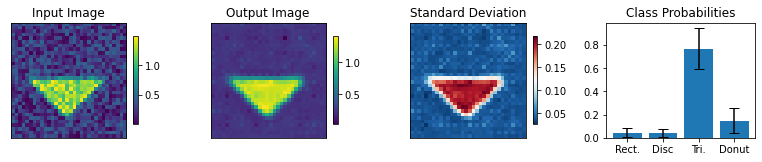

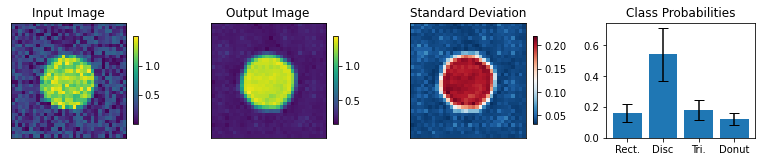

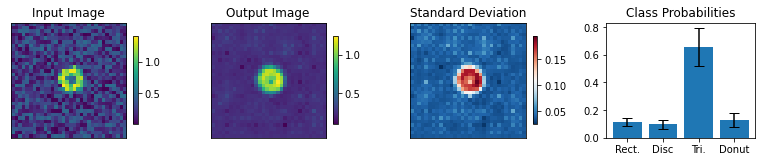

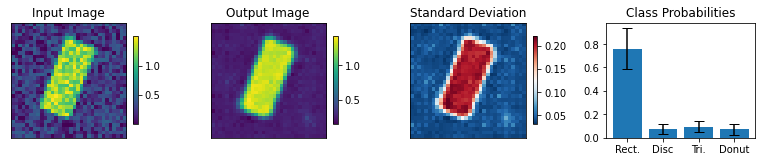

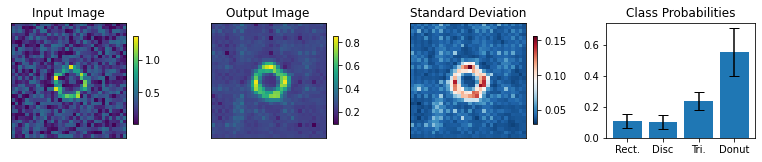

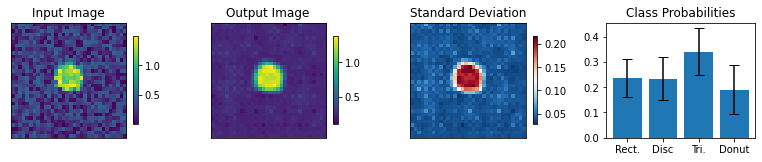

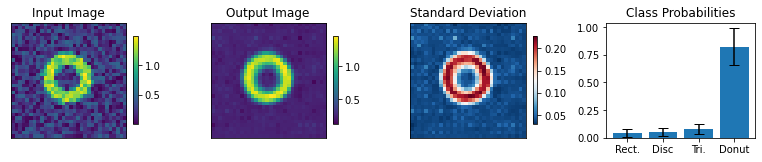

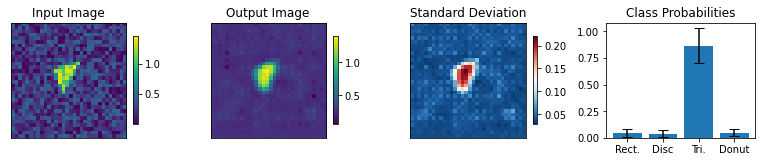

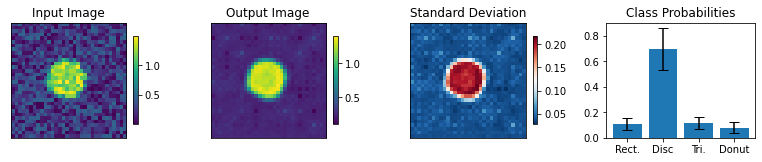

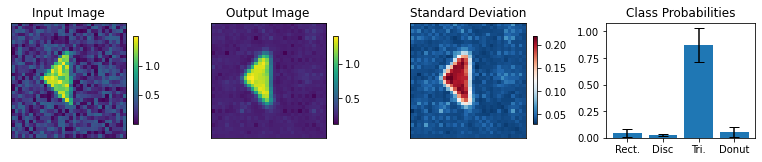

--------       Incorrectly labeled images  (10 max)   ----------


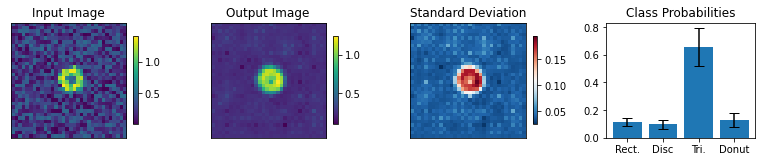

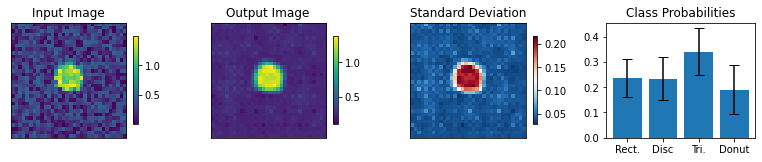

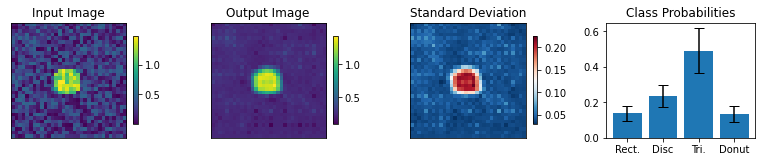

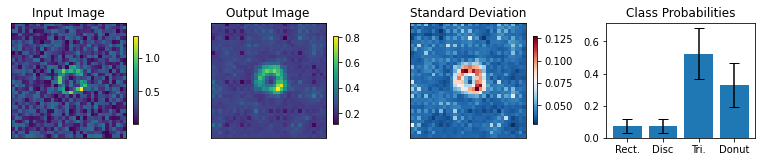

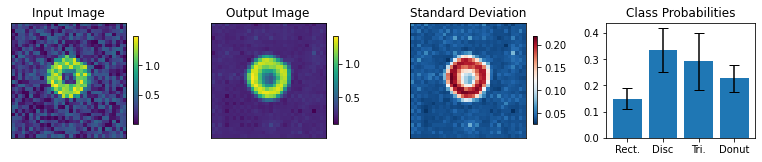

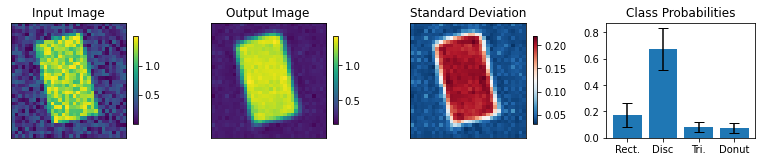

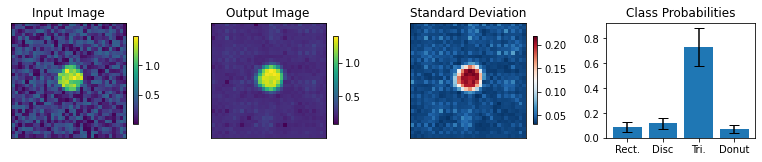

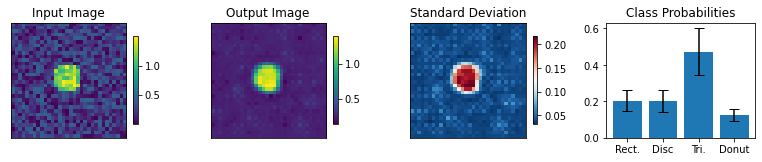

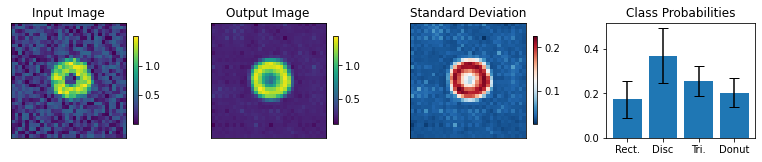

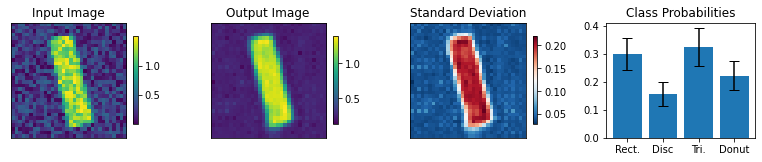

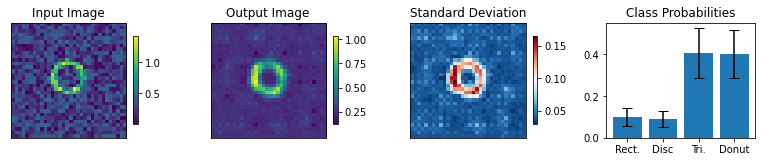

In [10]:
count = 0
print("--------       The first 10 images encountered     ----------")
for img, simg, p, sp, tlbl, ori in zip(results, sresults, pres, spres, true_lbl, inp_img):
    if count < 10:
        fig = paic.plot_autoencoder_and_label_results_with_std(
            input_img=ori[0].numpy(),
            output_img=img[0].numpy(),
            std_img=simg[0].numpy(),
            p_classification=p.numpy(),
            std_p_classification=sp.numpy(),
            class_names=["Rect.","Disc","Tri.","Donut"])
        plt.show()
        count += 1
    

print("--------       Incorrectly labeled images  (10 max)   ----------")
count = 0
for img, simg, p, sp, tlbl, ori in zip(results, sresults, pres, spres, true_lbl, inp_img):
    ilbl = np.argmax(p.numpy())
    if int(tlbl) != int(ilbl):
        fig = paic.plot_autoencoder_and_label_results_with_std(
            input_img=ori[0].numpy(),
            output_img=img[0].numpy(),
            std_img=simg[0].numpy(),
            p_classification=p.numpy(),
            std_p_classification=sp.numpy(),
            class_names=["Rect.","Disc","Tri.","Donut"])
        plt.show()
        count += 1
    if count > 10:
        break
        
    

